Sine:

GP EI: exact GP dEI Jacobian vs. estimated GP EI Jacobian

In [46]:
pip install pyGPGO


In [2]:
### Import:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from joblib import Parallel, delayed
from numpy.linalg import cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.stats import norm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

warnings.filterwarnings("ignore", category=RuntimeWarning)


In [3]:
n_start_AcqFunc = 250 #multi-start iterations to avoid local optima in AcqFunc optimization


In [4]:
### Inputs:

run_num_1 = 0
n_test = 500
eps = 1e-08

util_grad_exact = 'dEI_GP'
util_grad_approx = 'ExpectedImprovement'

n_init = 2 # random initialisations
iters = 1
opt = True


In [5]:
### Objective Function - Sin(x) 1-D:

def objfunc(x1_training):
    return operator * np.sin(x1_training)
    
# Constraints:
lb = 0
ub = 2 * np.pi
y_global_orig = 1

# Input array dimension(s):
dim = 1
operator = 1

# 1-D inputs' parameter bounds:
param = {'x1_training': ('cont', [lb, ub])}
    
# Test data:
x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list
  

In [7]:
class Acquisition_new(Acquisition):    
    def __init__(self, mode, eps=1e-08, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'dEI_GP': self.dEI_GP
        }

        self.f = mode_dict[mode]
    
    def dEI_GP(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = np.array((std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma)))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = df1 + df2

        df_arr = []
        
        for i in range(0, dim):
          df_arr.append([df])
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)


In [8]:
### Surrogate derivatives: 

cov_func = squaredExponential()

class dGaussianProcess(GaussianProcess):
    l = GaussianProcess(cov_func, optimize=opt).getcovparams()['l']
    sigmaf = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigmaf']
    sigman = GaussianProcess(cov_func, optimize=opt).getcovparams()['sigman']

    def AcqGrad(self, Xstar):
        Xstar = np.atleast_2d(Xstar)
        Kstar = squaredExponential.K(self, self.X, Xstar).T
        dKstar = Kstar * cdist(self.X, Xstar).T * -1
        
        v = solve(self.L, Kstar.T)
        dv = solve(self.L, dKstar.T)
        
        ds = -2 * np.diag(np.dot(dv.T, v))
        dm = np.dot(dKstar, self.alpha)
        return ds, dm


In [9]:
## dGPGO:

class dGPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08
    
    def d_optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfunc,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self.logger._printInit(self)
        for iteration in range(max_iter):
            self.d_optimizeAcq()
            self.updateGP()
            self.logger._printCurrent(self)

    def acqfunc(self, xnew, n_start=n_start_AcqFunc):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        ds, dm = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(-self.tau, new_mean, new_std, ds=ds, dm=dm)
        return -f, df

    def acqfunc_h(self, xnew, n_start=n_start_AcqFunc, eps=eps):
        f = self.acqfunc(xnew)[0]
        
        new_mean_h, new_var_h = self.GP.predict(xnew + eps, return_std=True)
        new_std_h = np.sqrt(new_var_h + eps)
        ds_h, dm_h = self.GP.AcqGrad(xnew + eps)
        f_h = self.A.d_eval(-self.tau, new_mean_h, new_std_h, ds=ds_h, dm=dm_h)[0]
        
        approx_grad = (-f_h - f)/eps
        return approx_grad


In [10]:
## est_GPGO:

class est_GPGO(GPGO):  
    n_start = n_start_AcqFunc
    eps = 1e-08
    
    def _optimizeAcq(self, method='L-BFGS-B', n_start=n_start_AcqFunc):
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        if self.n_jobs == 1:
            for index, start_point in enumerate(start_points_arr):
                res = minimize(self._acqWrapper, x0=start_point, method=method,
                               bounds=self.parameter_range)
                x_best[index], f_best[index] = res.x, np.atleast_1d(res.fun)[0]
        else:
            opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self._acqWrapper,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
            x_best = np.array([res.x for res in opt])
            f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr

        return x_best, f_best
    

In [11]:
### Plot Methods:

def plot_sine(gpgo, param, new=True):
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    y_hat, y_var = gpgo.GP.predict(x_test, return_std=True)
    std = np.sqrt(y_var)
    l, u = y_hat - 1.96 * std, y_hat + 1.96 * std # z-score, 95% confidence (two-tail)
    colours = ['Post', 'Random']
    if new:
        plt.figure(figsize=[7,5])
        plt.scatter(gpgo.GP.X, gpgo.GP.y, marker ='D', color = 'Red', label='Post-initialization ($\mathbf{x}$, $y$)')
        plt.scatter(gpgo.X, gpgo.y, marker ='D', color = 'Green', label='Random-initialization ($\mathbf{x}$, $y$)')
        plt.ylim(-3,3)
        plt.xlim(0, 2 * np.pi)
        plt.plot(x_test.flatten(), y_hat, color = 'Yellow', label='$\hat{\mu}_{GP}(\mathbf{x})$')
        plt.plot(x_test.flatten(), np.sin(x_test.flatten()), color = 'Orange', label='True function: y = sin($\mathbf{x}$)')
        plt.fill_between(x_test.flatten(), l, u, alpha=0.2, label='95% C.I. for $\mu_{GP}(\mathbf{x})$')
        title = 'Sine'
        plt.title(title, weight = 'bold')
        plt.xlabel("$\mathbf{x}$")
        plt.ylabel("sin($\mathbf{x}$)")
        plt.legend(loc=0)
        plt.show()

def plot_GP_dEI(dgpgo, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = -dGPGO.acqfunc(dgpgo, x_test)[0].flatten()
    plt.plot(x_test, a, color='Purple', label='GP dEI$(\mathbf{x})$')
    xbest = x_test[np.argmax(-GPGO.acqfunc(dgpgo, x_test)[0])][0]
    ybest = np.max(-dGPGO.acqfunc(dgpgo, x_test)[0])
    plt.scatter(xbest, ybest, marker ='D', color = 'Blue', label='GP dEI$(\mathbf{x})$: maximum')
    plt.ylim(-0.1 + min(a), max(a) + 0.1)
    plt.xlim(0, 2 * np.pi)
    plt.axvline(x=xbest, color='Black', label='GP dEI$(\mathbf{x})$: arg max $\mathbf{x}$')
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP dEI$(\mathbf{x})$")
    title = 'GP dEI'
    plt.suptitle(title, weight = 'bold')
    plt.show()

def plot_GP_EI_jac(gpgo, param, new):
    plt.figure(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    jac = -dGPGO.acqfunc(gpgo, x_test)[1].flatten()
    approx_jac = -dGPGO.acqfunc_h(gpgo, x_test).flatten()
    plt.plot(x_test, jac, color='Red', label='GP dEI$(\mathbf{x})$: exact GP EI Jacobian')
    plt.plot(x_test, approx_jac, color='Green', label='Estimated GP EI Jacobian')
    xbest = x_test[np.argmax(-dGPGO.acqfunc(gpgo, x_test)[0])][0]
    plt.axvline(x=xbest, color='Black', label='GP EI$(\mathbf{x})$: arg max $\mathbf{x}$')
    plt.ylim(-0.1 + min([min(approx_jac), min(jac)]), max([max(approx_jac), max(jac)]) + 0.1)
    plt.xlim(0, 2 * np.pi)
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP dEI$(\mathbf{x})$, GP deltaEI$(\mathbf{x})$")
    title = 'GP dEI'
    plt.suptitle(title, weight = 'bold')
    plt.show()

def plot_GP_dEI_vs_approx(dgpgo, est_GPGO, param, new):
    fig, ax = plt.subplots(figsize=[7,5])
    x_test = np.linspace(lb, ub, n_test).reshape((n_test, 1))
    a = -dGPGO.acqfunc(dgpgo, x_test)[0].flatten()
    plt.plot(x_test, a, color='Purple', label='GP EI$(\mathbf{x})$')
    ybest = np.max(-dGPGO.acqfunc(dgpgo, x_test)[0])
    xbest = x_test[np.argmax(-dGPGO.acqfunc(dgpgo, x_test)[0])][0]
    plt.scatter(xbest, ybest, marker ='D', color = 'Blue', label='GP EI$(\mathbf{x})$: maximum')
    plt.ylim(-0.1 + min(a), max(a) + 0.1)
    plt.xlim(0, 2 * np.pi)
    xbest_approx = est_GPGO.x_best[np.argmax(np.array(-est_GPGO.f_best))][0]
    plt.axvline(x=xbest, color = 'Black', label='GP EI$(\mathbf{x})$: arg max $\mathbf{x}$')
    plt.axvline(x=xbest_approx, color = 'Brown', ls = '--', label='Alternative GP EI$(\mathbf{x})$: arg max $\mathbf{x}$')
    plt.legend(loc=0)
    plt.xlabel("$\mathbf{x}$")
    plt.ylabel("GP dEI$(\mathbf{x})$")
    title = 'GP dEI'
    plt.suptitle(title, weight = 'bold')
    plt.show()


In [12]:
### Random-initialisation: Bayesian optimisation

### EXACT GP EI Jacobian

np.random.seed(run_num_1)
surrogate_exact_0 = dGaussianProcess(cov_func, optimize=opt)

exact_0 = dGPGO(surrogate_exact_0, Acquisition_new(util_grad_exact), objfunc, param)
exact_0.run(init_evals=n_init, max_iter=iters-1)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691


In [13]:
### Random-initialisation: Bayesian optimisation

### versus ESTIMATED GP EI Jacobian

np.random.seed(run_num_1)
surrogate_approx_0 = GaussianProcess(cov_func, optimize=opt)

approx_0 = est_GPGO(surrogate_approx_0, Acquisition(util_grad_approx), objfunc, param)
approx_0.run(init_evals=n_init, max_iter=iters-1)


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691


In [14]:
### Random-initialisation: GP EI arg max x, max
np.random.seed(run_num_1)

AcqFuncMaxExact_0 = np.max(-dGPGO.acqfunc(exact_0, x_test)[0])
XBestExact_0 = x_test[np.argmax(-dGPGO.acqfunc(exact_0, x_test)[0])][0]

XBestExactGradExact_0 = exact_0.acqfunc(XBestExact_0)[1][0][0][0]
XBestApproxGradExact_0 = exact_0.acqfunc_h(XBestExact_0)[0]

print("Exact GP EI Jacobian: arg max  x:", np.round(XBestExactGradExact_0, 4))
print("Estm. GP EI Jacobian: arg max  x:", np.round(XBestApproxGradExact_0, 4))


Exact GP EI Jacobian: arg max  x: 0.0474
Estm. GP EI Jacobian: arg max  x: -0.0001


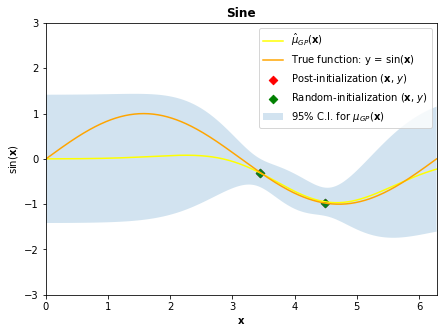

In [15]:
### Random-initialisation: plots

plot_sine(exact_0, param, new=True)


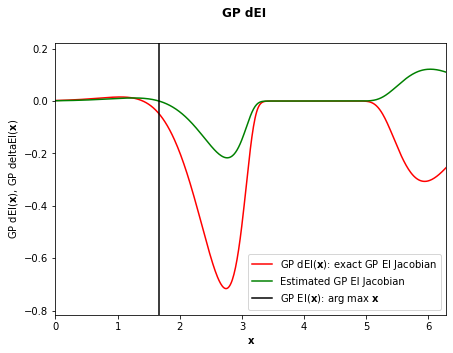

Max. Exact GP EI Jacobian:  0.0153
Min. Exact GP EI Jacobian: -0.7158
Max. Estm. GP EI Jacobian:  0.1214
Min. Estm. GP EI Jacobian: -0.2168
Exact Jacobian: arg max x: 0.0474
Estm. Jacobian: arg max x: -0.0001


In [16]:
### Random-initialisation: STP EI Jacobian' plots - exact versus estimated

plot_GP_EI_jac(exact_0, param, new=True)
print("Max. Exact GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc(exact_0, x_test)[1])[0][0], 4))
print("Min. Exact GP EI Jacobian:", np.round(min(-dGPGO.acqfunc(exact_0, x_test)[1])[0][0], 4))
print("Max. Estm. GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc_h(exact_0, x_test)), 4))
print("Min. Estm. GP EI Jacobian:", np.round(min(-dGPGO.acqfunc_h(exact_0, x_test)), 4))
print("Exact Jacobian: arg max x:", np.round(XBestExactGradExact_0, 4))
print("Estm. Jacobian: arg max x:", np.round(XBestApproxGradExact_0, 4))


In [17]:
min(-dGPGO.acqfunc(exact_0, x_test)[1])[0][0]

-0.7158356355687903

In [18]:
### Post-initialisation: iteration 1 Bayesian optimisation

### EXACT GP EI Jacobian

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=opt)

exact_1 = dGPGO(surrogate_exact_1, Acquisition_new(util_grad_exact), objfunc, param)
exact_1.run(init_evals=n_init, max_iter=iters)

a_exact_1 = np.array(-exact_1.f_best)
xbest_exact_1 = exact_1.x_best[np.argmax(a_exact_1)][0]
regret_exact_1 = y_global_orig - objfunc(xbest_exact_1)

print("Exact GP EI Jacobian: Max. GP EI", np.round(np.max(a_exact_1), 4))
print("Exact GP EI Jacobian: regret", np.round(regret_exact_1, 4))


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691
1      	 [1.66399209]. 	  0.9956604172034629 	 0.9956604172034629
Exact GP EI Jacobian: Max. GP EI 0.173
Exact GP EI Jacobian: regret 0.0043


In [19]:
### Post-initialisation: iteration 1 Bayesian optimisation

### versus ESTIMATED GP EI Jacobian

np.random.seed(run_num_1)
surrogate_approx_1 = GaussianProcess(cov_func, optimize=opt)

approx_1 = est_GPGO(surrogate_approx_1, Acquisition(util_grad_approx), objfunc, param)
approx_1.run(init_evals=n_init, max_iter=iters)

a_approx_1 = np.array(-approx_1.f_best)
xbest_approx_1 = approx_1.x_best[np.argmax(a_approx_1)][0]
regret_approx_1 = y_global_orig - objfunc(xbest_approx_1)

print("Estimated GP EI Jacobian: Max. GP EI", np.round(np.max(a_approx_1), 4))
print("Estimated GP EI Jacobian: regret", np.round(regret_approx_1, 4))


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691
1      	 [1.90357748]. 	  0.9451374717390602 	 0.9451374717390602
Estimated GP EI Jacobian: Max. GP EI 0.4955
Estimated GP EI Jacobian: regret 0.0549


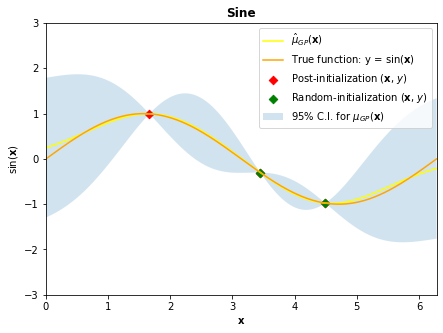

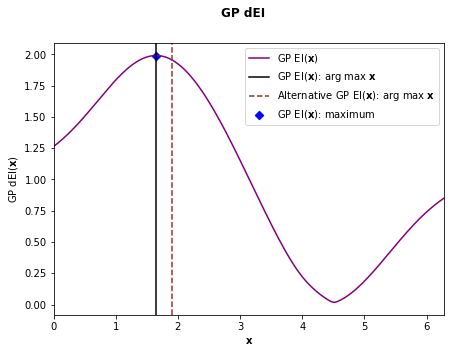

In [20]:
### Post-initialisation: iteration 1 plots

plot_sine(exact_1, param, new=True)
plot_GP_dEI_vs_approx(exact_1, approx_1, param, new=True)


In [21]:
### Post-initialisation: iteration 1 GP EI arg max x, max

np.random.seed(run_num_1)

AcqFuncMaxExact_1 = np.max(-dGPGO.acqfunc(exact_1, x_test)[0])
XBestExact_1 = x_test[np.argmax(-dGPGO.acqfunc(exact_1, x_test)[0])][0]

XBestExactGradExact_1 = exact_1.acqfunc(XBestExact_1)[1][0][0][0]
XBestApproxGradExact_1 = exact_1.acqfunc_h(XBestExact_1)[0]

print("Exact GP EI Jacobian: arg max  x:", np.round(XBestExactGradExact_1, 4))
print("Estm. GP EI Jacobian: arg max  x:", np.round(XBestApproxGradExact_1, 4))


Exact GP EI Jacobian: arg max  x: -0.0003
Estm. GP EI Jacobian: arg max  x: -0.0002


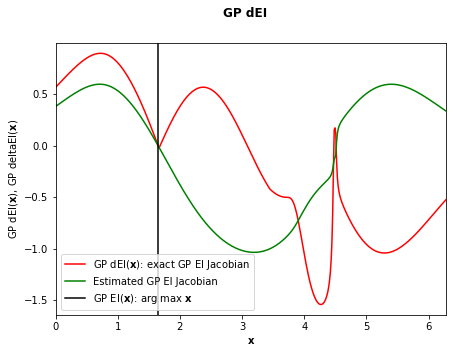

Max. Exact GP EI Jacobian:  0.8967
Min. Exact GP EI Jacobian: -1.5411
Max. Estm. GP EI Jacobian:  0.5968
Min. Estm. GP EI Jacobian: -1.035
Exact GP EI Jacobian: arg max x: -0.0003
Estm. GP EI Jacobian: arg max x: -0.0002


In [22]:
### Post-initialisation: iteration 1 GP EI Jacobian' plots - exact versus estimated

plot_GP_EI_jac(exact_1, param, new=True)
print("Max. Exact GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc(exact_1, x_test)[1])[0][0], 4))
print("Min. Exact GP EI Jacobian:", np.round(min(-dGPGO.acqfunc(exact_1, x_test)[1])[0][0], 4))
print("Max. Estm. GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc_h(exact_1, x_test)), 4))
print("Min. Estm. GP EI Jacobian:", np.round(min(-dGPGO.acqfunc_h(exact_1, x_test)), 4))
print("Exact GP EI Jacobian: arg max x:", np.round(XBestExactGradExact_1, 4))
print("Estm. GP EI Jacobian: arg max x:", np.round(XBestApproxGradExact_1, 4))


In [23]:
### Post-initialisation: iteration 2 Bayesian optimisation

### EXACT GP EI Jacobian

np.random.seed(run_num_1)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=opt)

exact_2 = dGPGO(surrogate_exact_2, Acquisition_new(util_grad_exact), objfunc, param)
exact_2.run(init_evals=n_init, max_iter=iters+1)

a_exact_2 = np.array(-exact_2.f_best)
xbest_exact_2 = exact_2.x_best[np.argmax(a_exact_2)][0]
regret_exact_2 = y_global_orig - objfunc(xbest_exact_2)

print("Exact GP EI Jacobian: Max. GP EI", np.round(np.max(a_exact_2), 4))
print("Exact GP EI Jacobian: regret", np.round(regret_exact_2, 4))


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691
1      	 [1.66399209]. 	  0.9956604172034629 	 0.9956604172034629
2      	 [1.64970468]. 	  0.9968883509017231 	 0.9968883509017231
Exact GP EI Jacobian: Max. GP EI 1.9914
Exact GP EI Jacobian: regret 0.0031


In [24]:
### Post-initialisation: iteration 2 Bayesian optimisation

### versus ESTIMATED GP EI Jacobian

np.random.seed(run_num_1)
surrogate_approx_2 = GaussianProcess(cov_func, optimize=opt)

approx_2 = est_GPGO(surrogate_approx_2, Acquisition(util_grad_approx), objfunc, param)
approx_2.run(init_evals=n_init, max_iter=iters+1)

a_approx_2 = np.array(-approx_2.f_best)
xbest_approx_2 = approx_2.x_best[np.argmax(a_approx_2)][0]
regret_approx_2 = y_global_orig - objfunc(xbest_approx_1) ### Iteration 1's y-value is closer to y_global_orig

print("Estimated GP EI Jacobian: Max. GP EI", np.round(np.max(a_approx_2), 4))
print("Estimated GP EI Jacobian: regret", np.round(regret_approx_2, 4))


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691
1      	 [1.90357748]. 	  0.9451374717390602 	 0.9451374717390602
2      	 [1.09255415]. 	  0.8878052780090047 	 0.9451374717390602
Estimated GP EI Jacobian: Max. GP EI 0.1143
Estimated GP EI Jacobian: regret 0.0549


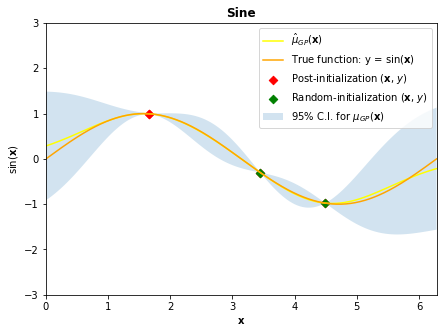

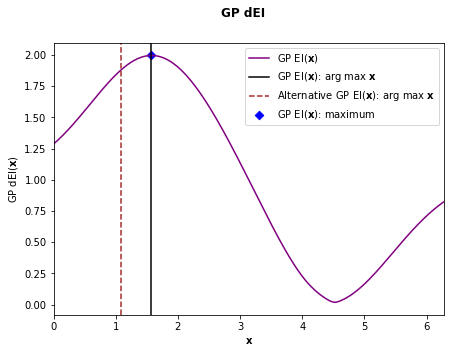

In [25]:
### Post-initialisation: iteration 2 plots

plot_sine(exact_2, param, new=True)
plot_GP_dEI_vs_approx(exact_2, approx_2, param, new=True)


In [26]:
### Post-initialisation: iteration 2 GP EI arg max x, max
np.random.seed(run_num_1)

AcqFuncMaxExact_2 = np.max(-dGPGO.acqfunc(exact_2, x_test)[0])
XBestExact_2 = x_test[np.argmax(-dGPGO.acqfunc(exact_2, x_test)[0])][0]

XBestExactGradExact_2 = exact_2.acqfunc(XBestExact_2)[1][0][0][0]
XBestApproxGradExact_2 = exact_2.acqfunc_h(XBestExact_2)[0]

print("Exact GP EI Jacobian: arg max  x:", np.round(XBestExactGradExact_2, 4))
print("Estm. GP EI Jacobian: arg max  x:", np.round(XBestApproxGradExact_2, 4))


Exact GP EI Jacobian: arg max  x: -0.0052
Estm. GP EI Jacobian: arg max  x: -0.0026


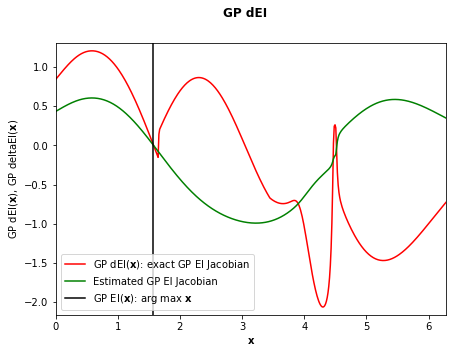

Max. Exact GP EI Jacobian:  1.2089
Min. Exact GP EI Jacobian: -2.0651
Max. Estm. GP EI Jacobian:  0.6064
Min. Estm. GP EI Jacobian: -0.9934
Exact GP EI Jacobian: arg max x: -0.0052
Estm. GP EI Jacobian: arg max x: -0.0026


In [27]:
### Post-initialisation: iteration 2 GP EI Jacobian' plots - exact versus estimated

plot_GP_EI_jac(exact_2, param, new=True)
print("Max. Exact GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc(exact_2, x_test)[1])[0][0], 4))
print("Min. Exact GP EI Jacobian:", np.round(min(-dGPGO.acqfunc(exact_2, x_test)[1])[0][0], 4))
print("Max. Estm. GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc_h(exact_2, x_test)), 4))
print("Min. Estm. GP EI Jacobian:", np.round(min(-dGPGO.acqfunc_h(exact_2, x_test)), 4))
print("Exact GP EI Jacobian: arg max x:", np.round(XBestExactGradExact_2, 4))
print("Estm. GP EI Jacobian: arg max x:", np.round(XBestApproxGradExact_2, 4))


In [28]:
### Post-initialisation: iteration 3 Bayesian optimisation

### EXACT GP EI Jacobian

np.random.seed(run_num_1)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=opt)

exact_3 = dGPGO(surrogate_exact_3, Acquisition_new(util_grad_exact), objfunc, param)
exact_3.run(init_evals=n_init, max_iter=iters+2)

a_exact_3 = np.array(-exact_3.f_best)
xbest_exact_3 = exact_3.x_best[np.argmax(a_exact_3)][0]
regret_exact_3 = y_global_orig - objfunc(xbest_exact_3)

print("Exact GP EI Jacobian: Max. GP EI", np.round(np.max(a_exact_3), 4))
print("Exact GP EI Jacobian: regret", np.round(regret_exact_3, 4))


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691
1      	 [1.66399209]. 	  0.9956604172034629 	 0.9956604172034629
2      	 [1.64970468]. 	  0.9968883509017231 	 0.9968883509017231
3      	 [1.57642514]. 	  0.9999841582756325 	 0.9999841582756325
Exact GP EI Jacobian: Max. GP EI 1.9966
Exact GP EI Jacobian: regret 0.0


In [29]:
### Post-initialisation: iteration 3 Bayesian optimisation

### versus ESTIMATED GP EI Jacobian

np.random.seed(run_num_1)
surrogate_approx_3 = GaussianProcess(cov_func, optimize=opt)

approx_3 = est_GPGO(surrogate_approx_3, Acquisition(util_grad_approx), objfunc, param)
approx_3.run(init_evals=n_init, max_iter=iters+2)

a_approx_3 = np.array(-approx_3.f_best)
xbest_approx_3 = approx_3.x_best[np.argmax(a_approx_3)][0]
regret_approx_3 = y_global_orig - objfunc(xbest_approx_3)

print("Estimated GP EI Jacobian: Max. GP EI", np.round(np.max(a_approx_3), 4))
print("Estimated GP EI Jacobian: regret", np.round(regret_approx_3, 4))


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691
1      	 [1.90357748]. 	  0.9451374717390602 	 0.9451374717390602
2      	 [1.09255415]. 	  0.8878052780090047 	 0.9451374717390602
3      	 [1.55822889]. 	  0.9999210308501604 	 0.9999210308501604
Estimated GP EI Jacobian: Max. GP EI 0.0562
Estimated GP EI Jacobian: regret 0.0001


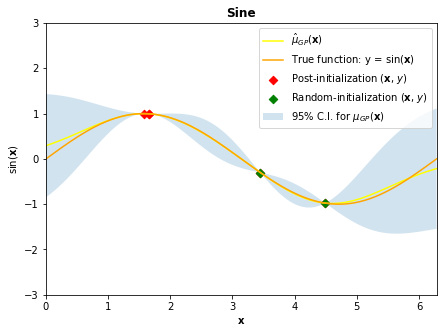

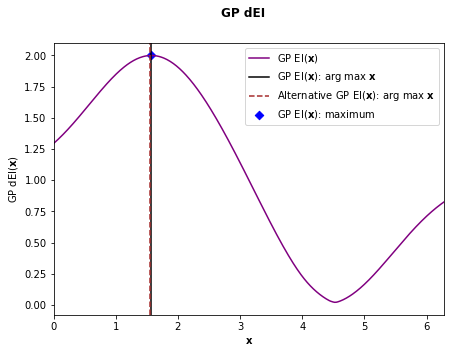

In [30]:
### Post-initialisation: iteration 3 plots

plot_sine(exact_3, param, new=True)
plot_GP_dEI_vs_approx(exact_3, approx_3, param, new=True)


In [31]:
### Post-initialisation: iteration 3 STP EI arg max x, max
np.random.seed(run_num_1)

AcqFuncMaxExact_3 = np.max(-dGPGO.acqfunc(exact_3, x_test)[0])
XBestExact_3 = x_test[np.argmax(-dGPGO.acqfunc(exact_3, x_test)[0])][0]

XBestExactGradExact_3 = exact_3.acqfunc(XBestExact_3)[1][0][0][0]
XBestApproxGradExact_3 = exact_3.acqfunc_h(XBestExact_3)[0]

print("Exact GP EI Jacobian: arg max  x:", np.round(XBestExactGradExact_3, 4))
print("Estm. GP EI Jacobian: arg max  x:", np.round(XBestApproxGradExact_3, 4))


Exact GP EI Jacobian: arg max  x: 0.0031
Estm. GP EI Jacobian: arg max  x: 0.0015


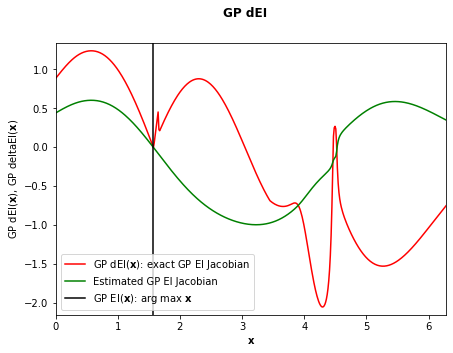

Max. Exact GP EI Jacobian:  1.2387
Min. Exact GP EI Jacobian: -2.0505
Max. Estm. GP EI Jacobian:  0.6034
Min. Estm. GP EI Jacobian: -0.9945
Exact GP EI Jacobian: arg max x: 0.0031
Estm. GP EI Jacobian: arg max x: 0.0015


In [32]:
### Post-initialisation: iteration 3 GP EI Jacobian' plots - exact versus estimated

plot_GP_EI_jac(exact_3, param, new=True)
print("Max. Exact GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc(exact_3, x_test)[1])[0][0], 4))
print("Min. Exact GP EI Jacobian:", np.round(min(-dGPGO.acqfunc(exact_3, x_test)[1])[0][0], 4))
print("Max. Estm. GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc_h(exact_3, x_test)), 4))
print("Min. Estm. GP EI Jacobian:", np.round(min(-dGPGO.acqfunc_h(exact_3, x_test)), 4))
print("Exact GP EI Jacobian: arg max x:", np.round(XBestExactGradExact_3, 4))
print("Estm. GP EI Jacobian: arg max x:", np.round(XBestApproxGradExact_3, 4))


In [33]:
### Post-initialisation: iteration 4 Bayesian optimisation

### EXACT GP EI Jacobian

np.random.seed(run_num_1)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=opt)

exact_4 = dGPGO(surrogate_exact_4, Acquisition_new(util_grad_exact), objfunc, param)
exact_4.run(init_evals=n_init, max_iter=iters+3)

a_exact_4 = np.array(-exact_4.f_best)
xbest_exact_4 = exact_4.x_best[np.argmax(a_exact_4)][0]
regret_exact_4 = y_global_orig - objfunc(xbest_exact_4)

print("Exact GP EI Jacobian: Max. GP EI", np.round(np.max(a_exact_4), 4))
print("Exact GP EI Jacobian: regret", np.round(regret_exact_4, 4))


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691
1      	 [1.66399209]. 	  0.9956604172034629 	 0.9956604172034629
2      	 [1.64970468]. 	  0.9968883509017231 	 0.9968883509017231
3      	 [1.57642514]. 	  0.9999841582756325 	 0.9999841582756325
4      	 [1.57249288]. 	  0.9999985608512583 	 0.9999985608512583
Exact GP EI Jacobian: Max. GP EI 2.0
Exact GP EI Jacobian: regret 0.0


In [34]:
### Post-initialisation: iteration 4 Bayesian optimisation

### versus ESTIMATED GP EI Jacobian

np.random.seed(run_num_1)
surrogate_approx_4 = GaussianProcess(cov_func, optimize=opt)

approx_4 = est_GPGO(surrogate_exact_4, Acquisition(util_grad_approx), objfunc, param)
approx_4.run(init_evals=n_init, max_iter=iters+3)

a_approx_4 = np.array(-approx_4.f_best)
xbest_approx_4 = approx_4.x_best[np.argmax(a_approx_4)][0]
regret_approx_4 = y_global_orig - objfunc(xbest_approx_3) ### Iteration 3's y-value is closest to y_global_orig

print("Estimated GP EI Jacobian: Max. GP EI", np.round(np.max(a_approx_4), 4))
print("Estimated GP EI Jacobian: regret", np.round(regret_approx_4, 4))


Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.44829694]. 	  -0.301918370765691 	 -0.301918370765691
init   	 [4.49366732]. 	  -0.9761756231500798 	 -0.301918370765691
1      	 [1.90357748]. 	  0.9451374717390602 	 0.9451374717390602
2      	 [1.09255415]. 	  0.8878052780090047 	 0.9451374717390602
3      	 [1.55822889]. 	  0.9999210308501604 	 0.9999210308501604
4      	 [6.28318531]. 	  -2.4492935982947064e-16 	 0.9999210308501604
Estimated GP EI Jacobian: Max. GP EI 0.0054
Estimated GP EI Jacobian: regret 0.0001


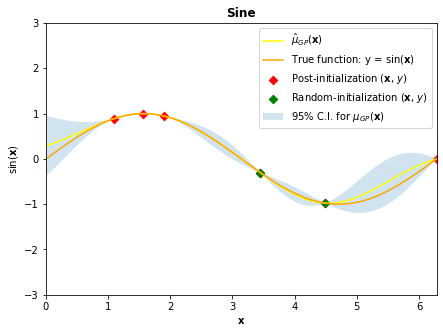

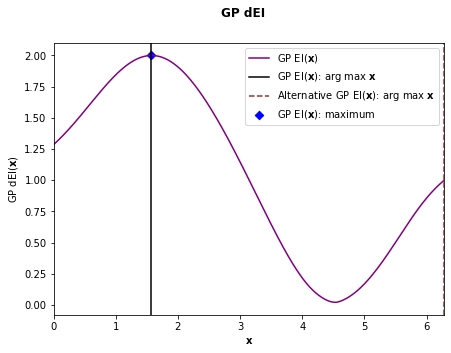

In [35]:
### Post-initialisation: iteration 4 plots

plot_sine(exact_4, param, new=True)
plot_GP_dEI_vs_approx(exact_4, approx_4, param, new=True)


In [36]:
### Post-initialisation: iteration 4 STP EI arg max x, max
np.random.seed(run_num_1)

AcqFuncMaxExact_4 = np.max(-dGPGO.acqfunc(exact_4, x_test)[0])
XBestExact_4 = x_test[np.argmax(-dGPGO.acqfunc(exact_4, x_test)[0])][0]

XBestExactGradExact_4 = exact_4.acqfunc(XBestExact_4)[1][0][0][0]
XBestApproxGradExact_4 = exact_4.acqfunc_h(XBestExact_4)[0]

print("Exact GP EI Jacobian: arg max  x:", np.round(XBestExactGradExact_4, 4))
print("Estm. GP EI Jacobian: arg max  x:", np.round(XBestApproxGradExact_4, 4))


Exact GP EI Jacobian: arg max  x: 0.0044
Estm. GP EI Jacobian: arg max  x: -0.0032


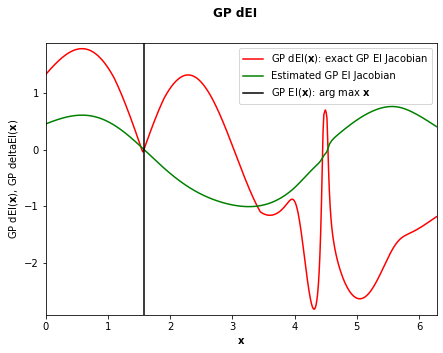

Max. Exact GP EI Jacobian:  1.7836
Min. Exact GP EI Jacobian: -2.8227
Max. Estm. GP EI Jacobian:  0.7607
Min. Estm. GP EI Jacobian: -1.0099
Exact GP EI Jacobian: arg max x: 0.0044
Estm. GP EI Jacobian: arg max x: -0.0032


In [37]:
### Post-initialisation: iteration 4 GP EI Jacobian' plots - exact versus estimated

plot_GP_EI_jac(exact_4, param, new=True)
print("Max. Exact GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc(exact_4, x_test)[1])[0][0], 4))
print("Min. Exact GP EI Jacobian:", np.round(min(-dGPGO.acqfunc(exact_4, x_test)[1])[0][0], 4))
print("Max. Estm. GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc_h(exact_4, x_test)), 4))
print("Min. Estm. GP EI Jacobian:", np.round(min(-dGPGO.acqfunc_h(exact_4, x_test)), 4))
print("Exact GP EI Jacobian: arg max x:", np.round(XBestExactGradExact_4, 4))
print("Estm. GP EI Jacobian: arg max x:", np.round(XBestApproxGradExact_4, 4))


**CHECKS:** exact_0 BayesOpt surrogate, exact GP EI Jacobian

In [38]:
### Exact GP EI Jacobian checks: exact_0 BayesOpt surrogate

f0, df0 = exact_0.acqfunc(x_test)
print("Max. Exact GP EI AcqFunc:  ", np.round(max(-dGPGO.acqfunc(exact_0, x_test)[0]), 4))
print("Min. Exact GP EI AcqFunc:  ", np.round(min(-dGPGO.acqfunc(exact_0, x_test)[0]), 4))
print("Max. Exact GP EI Jacobian: ", np.round(max(-dGPGO.acqfunc(exact_0, x_test)[1][0][0]), 4))
print("Min. Exact GP EI Jacobian:", np.round(min(-dGPGO.acqfunc(exact_0, x_test)[1][0][0]), 4))


Max. Exact GP EI AcqFunc:   0.173
Min. Exact GP EI AcqFunc:   0.0
Max. Exact GP EI Jacobian:  0.002
Min. Exact GP EI Jacobian: 0.002


In [39]:
### Exact GP EI Jacobian checks: exact_0 BayesOpt surrogate

mean0, var0 = exact_0.GP.predict(x_test, return_std=True)
std0 = np.sqrt(var0 + eps)
print("Max. GP Posterior Mean: ", np.round(max(mean0), 4))
print("Min. GP Posterior Mean:", np.round(min(mean0), 4))
print("Max. GP Posterior Std. Dev:", np.round(max(std0), 4))
print("Min. GP Posterior Std. Dev:", np.round(min(std0), 4))


Max. GP Posterior Mean:  0.081
Min. GP Posterior Mean: -0.9665
Max. GP Posterior Std. Dev: 0.7225
Min. GP Posterior Std. Dev: 0.1588


In [40]:
### Exact GP EI Jacobian checks: exact_0 BayesOpt surrogate

ds0, dm0 = exact_0.GP.AcqGrad(x_test)
print("Max. GP Posterior Mean 1st Derivative:", np.round(max(dm0), 4))
print("Min. GP Posterior Mean 1st Derivative:", np.round(min(dm0), 4))
print("Max. GP Posterior Variance 1st Derivative: ", np.round(max(ds0), 4))
print("Min. GP Posterior Variance 1st Derivative:", np.round(min(ds0), 4))


Max. GP Posterior Mean 1st Derivative: 1.3703
Min. GP Posterior Mean 1st Derivative: -0.4206
Max. GP Posterior Variance 1st Derivative:  1.9477
Min. GP Posterior Variance 1st Derivative: 0.0001


In [41]:
### Exact GP EI Jacobian checks: exact_0 BayesOpt surrogate

tau0 = -exact_0.tau
gamma0 = (mean0 - tau0)/(std0 + eps)
print("tau:", np.round(tau0, 4))
print("Max. gamma:", np.round(max(gamma0), 4))
print("Min. gamma:", np.round(min(gamma0), 4))


tau: 0.3019
Max. gamma: -0.3427
Min. gamma: -7.8397


In [42]:
### Exact GP EI Jacobian checks: exact_0 BayesOpt surrogate

dsdx0 = ds0 / (2 * (std0 + eps))
dmdx0 = (dm0 - gamma0 * dsdx0) / (std0 + eps)
print("Max. GP Posterior Std. Dev. 1st Derivative: ", np.round(max(dsdx0), 4))
print("Min. GP Posterior Std. Dev. 1st Derivative:", np.round(min(dsdx0), 4))
print("Max. gamma 1st Derivative:", np.round(max(dmdx0), 4))
print("Min. gamma 1st Derivative:", np.round(min(dmdx0), 4))


Max. GP Posterior Std. Dev. 1st Derivative:  4.9228
Min. GP Posterior Std. Dev. 1st Derivative: 0.0001
Max. gamma 1st Derivative: 142.5155
Min. gamma 1st Derivative: -0.1074


In [43]:
### Exact GP EI Jacobian checks: exact_0 BayesOpt surrogate

df0_check = -f0/(std0 + eps) * dsdx0 + (std0 + eps) * norm.cdf(gamma0) * dmdx0

print("Max. GP EI 1st Derivative - check:", np.round(max(-df0_check), 4))
print("Min. GP EI 1st Derivative - check:", np.round(min(-df0_check), 4))


Max. GP EI 1st Derivative - check: 0.0153
Min. GP EI 1st Derivative - check: -0.7158


In [44]:
### Exact GP EI Jacobian checks: exact_0 BayesOpt surrogate

print("Max. GP EI 1st Derivative:", np.round(max(-df0)[0][0], 4))
print("Min. GP EI 1st Derivative:", np.round(min(-df0)[0][0], 4))


Max. GP EI 1st Derivative: 0.0153
Min. GP EI 1st Derivative: -0.7158


In [45]:
np.random.seed(run_num_1)

new_mean, new_var = exact_0.GP.predict(x_test, return_std=True)
new_std = np.sqrt(new_var + eps)
new_ds, new_dm = exact_0.GP.AcqGrad(x_test)

exact_0.A.dEI_GP(-exact_0.tau, new_mean, new_std, new_ds, new_dm)


(array([1.62388712e-01, 1.62401642e-01, 1.62415077e-01, 1.62429032e-01,
        1.62443527e-01, 1.62458577e-01, 1.62474203e-01, 1.62490421e-01,
        1.62507251e-01, 1.62524713e-01, 1.62542827e-01, 1.62561612e-01,
        1.62581090e-01, 1.62601283e-01, 1.62622210e-01, 1.62643896e-01,
        1.62666362e-01, 1.62689632e-01, 1.62713728e-01, 1.62738675e-01,
        1.62764498e-01, 1.62791220e-01, 1.62818867e-01, 1.62847465e-01,
        1.62877040e-01, 1.62907617e-01, 1.62939224e-01, 1.62971888e-01,
        1.63005635e-01, 1.63040495e-01, 1.63076494e-01, 1.63113662e-01,
        1.63152026e-01, 1.63191616e-01, 1.63232461e-01, 1.63274590e-01,
        1.63318032e-01, 1.63362817e-01, 1.63408975e-01, 1.63456535e-01,
        1.63505528e-01, 1.63555983e-01, 1.63607929e-01, 1.63661398e-01,
        1.63716417e-01, 1.63773017e-01, 1.63831226e-01, 1.63891074e-01,
        1.63952588e-01, 1.64015798e-01, 1.64080731e-01, 1.64147413e-01,
        1.64215872e-01, 1.64286133e-01, 1.64358221e-01, 1.644321